# Machine Learning -Regression <a class="tocSkip">

Build mechine learning model to predict the investment return (annual return of investment)

## Library 

In [56]:
# Load general utilities
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os
from IPython import get_ipython
ipython = get_ipython()
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Load sklearn utilities
import sklearn
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, \
roc_auc_score, roc_curve, precision_recall_curve, auc, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error, make_scorer
import joblib

# Load classifiers
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier


# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

## Import data

In [2]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'LC_ML_prep.csv', low_memory=False, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d'] )
end = time.time()
print('It takes  ' + str(round((end-start)/60, 1)) +' min to read the data')

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


It takes  0.4 min to read the data


In [3]:
# To ensure all the loans were matured, we only consider issue date before 2015 
df = df[df['issue_d']<'2015']

In [4]:
df.head()

,home_ownership,verification_status,purpose,addr_state,pub_rec,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,Log_Annual_ROI,issue_d,earliest_cr_line,last_pymnt_d,target
1,MORTGAGE,Not Verified,debt_consolidation,TX,0.0,36,7,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3.0,-1.346243,2013-12-01,2003-09-01,2016-06-01,0
2,OWN,Verified,debt_consolidation,MI,0.0,36,6,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10.0,-1.193486,2013-12-01,1986-10-01,2016-07-01,0
3,RENT,Not Verified,debt_consolidation,NC,0.0,36,6,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4.0,-1.167860,2013-12-01,2009-12-01,2016-04-01,0
5,MORTGAGE,Not Verified,debt_consolidation,CT,0.0,36,7,37.027454,6.62,21.6,12000.0,12000.0,368.45,12.0,764.0,13263.954639,5.021189,1.147676,4.119520,-inf,10.0,-1.481653,2013-12-01,1994-03-01,2017-01-01,0
6,RENT,Not Verified,debt_consolidation,NC,1.0,36,6,37.027454,12.85,81.9,14000.0,14000.0,470.71,6.0,674.0,16945.318783,4.944483,1.000868,3.566555,0.0,4.0,-1.194953,2013-12-01,1988-06-01,2017-01-01,0


In [5]:
df.shape

(286170, 26)

It is computationally expensive to run ML models on this dataset. So we decide to take a small sample of this dataset.

In [6]:
# resample data (35%)
df_sam=df.sample(frac=0.35, replace=False, random_state=42)

In [7]:
df_sam.shape

(100160, 26)

## Feature Engineering

#### 1. datetime
Converting the datetime columns into integer number of year and month 

In [8]:
col_dt = df_sam.select_dtypes('datetime64').columns
print(col_dt)
print('number of datetime features =', len(col_dt))

Index(['issue_d', 'earliest_cr_line', 'last_pymnt_d'], dtype='object')
number of datetime features = 3


In [9]:
df_sam['issue_y']=pd.to_datetime(df_sam['issue_d']).apply(lambda x: int(x.strftime('%Y')))
df_sam['issue_m']=pd.to_datetime(df_sam['issue_d']).apply(lambda x: int(x.strftime('%m')))
df_sam['earliest_cr_line_y']=pd.to_datetime(df_sam['earliest_cr_line']).apply(lambda x: int(x.strftime('%Y')))
df_sam['earliest_cr_line_m']=pd.to_datetime(df_sam['earliest_cr_line']).apply(lambda x: int(x.strftime('%m')))
df_sam['last_pymnt_y']=pd.to_datetime(df_sam['last_pymnt_d']).apply(lambda x: int(x.strftime('%Y')))
df_sam['last_pymnt_m']=pd.to_datetime(df_sam['last_pymnt_d']).apply(lambda x: int(x.strftime('%m')))

In [10]:
# drop datetime columns
df_sam.drop(col_dt, axis=1, inplace=True)

#### 2. Categorical variable
one-hot encoding

In [11]:
col_cat = df_sam.select_dtypes('object').columns
print(col_cat)
print('number of categorical features =', len(col_cat))

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state'], dtype='object')
number of categorical features = 4


In [12]:
#one-hot encoding
df_cat = pd.get_dummies(df_sam[col_cat],dummy_na=True)
df_cat.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,addr_state_AK,...,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
236609,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
273214,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83110,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289411,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
364895,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3. Numerical variable

In [13]:
col_num = df_sam.select_dtypes('float').columns 
print(col_num)
print('number of numerical feature =', len(col_num))

Index(['pub_rec', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt',
       'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt',
       'log_annual_inc', 'log_dti', 'log_revol_bal', 'log_delinq_2yrs',
       'emp_length_num', 'Log_Annual_ROI'],
      dtype='object')
number of numerical feature = 16


In [15]:
col_int = df_sam.select_dtypes('int64').columns 
print(col_int)

Index(['term_num', 'grade_num', 'target', 'issue_y', 'issue_m',
       'earliest_cr_line_y', 'earliest_cr_line_m', 'last_pymnt_y',
       'last_pymnt_m'],
      dtype='object')


In [16]:
df_num = pd.concat((df_sam[col_num], df_sam[col_int]),axis=1)
df_num.drop(['log_delinq_2yrs'], axis=1, inplace=True) # drop this feature, because it contains infinity.
df_num.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,emp_length_num,Log_Annual_ROI,term_num,grade_num,target,issue_y,issue_m,earliest_cr_line_y,earliest_cr_line_m,last_pymnt_y,last_pymnt_m
236609,0.0,20.994271,17.57,74.8,13325.0,13325.0,335.26,9.0,684.0,7040.460000,4.623249,1.319938,4.131587,5.0,-0.514900,60,4,1,2014,10,1999,7,2016,7
273214,0.0,25.035422,10.99,37.4,4000.0,4000.0,130.94,10.0,669.0,3295.080000,4.318063,1.154120,3.830781,0.0,-1.051898,36,6,1,2014,8,2009,10,2016,9
83110,0.0,16.000329,17.77,75.6,25000.0,25000.0,900.93,13.0,669.0,29911.816859,4.778151,1.211121,4.464936,2.0,-0.841639,36,4,0,2013,6,2004,4,2014,10
289411,0.0,32.000657,12.99,23.7,9125.0,9125.0,307.42,11.0,724.0,11040.748611,4.322219,1.211921,4.033142,3.0,-1.130301,36,5,0,2014,7,2002,3,2017,3
364895,0.0,36.008953,8.90,77.5,9600.0,9600.0,304.84,8.0,669.0,10973.863349,4.829304,1.351216,3.979002,2.0,-1.341210,36,7,0,2014,3,2005,5,2017,3


In [17]:
df_num.shape

(100160, 24)

In [18]:
df_sam.rename(columns={"target": "default"},inplace=True)

In [19]:
df_num.rename(columns={"target": "default"},inplace=True)

In [20]:
df_num.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,emp_length_num,Log_Annual_ROI,term_num,grade_num,default,issue_y,issue_m,earliest_cr_line_y,earliest_cr_line_m,last_pymnt_y,last_pymnt_m
236609,0.0,20.994271,17.57,74.8,13325.0,13325.0,335.26,9.0,684.0,7040.460000,4.623249,1.319938,4.131587,5.0,-0.514900,60,4,1,2014,10,1999,7,2016,7
273214,0.0,25.035422,10.99,37.4,4000.0,4000.0,130.94,10.0,669.0,3295.080000,4.318063,1.154120,3.830781,0.0,-1.051898,36,6,1,2014,8,2009,10,2016,9
83110,0.0,16.000329,17.77,75.6,25000.0,25000.0,900.93,13.0,669.0,29911.816859,4.778151,1.211121,4.464936,2.0,-0.841639,36,4,0,2013,6,2004,4,2014,10
289411,0.0,32.000657,12.99,23.7,9125.0,9125.0,307.42,11.0,724.0,11040.748611,4.322219,1.211921,4.033142,3.0,-1.130301,36,5,0,2014,7,2002,3,2017,3
364895,0.0,36.008953,8.90,77.5,9600.0,9600.0,304.84,8.0,669.0,10973.863349,4.829304,1.351216,3.979002,2.0,-1.341210,36,7,0,2014,3,2005,5,2017,3


### Feature Selection

#### 1. Eliminate correlated features 

- From the Pearson correlation heatmap, we found that for prediction on default as target, the annual ROI is the most predicative of all features, followed by grade, and interest rate; while total payment has negative impact.
- To avoid overfitting, we eliminated the features that are highly correlated with each other, and only keep the following features.  (multicollinearity)
 

#### - Eliminate feature that is uncorrelated with target

In [21]:
#Correlation with output variable
cor = df_num.corr()
cor_target = abs(cor["Log_Annual_ROI"])

# only keep correlation >0.01 with target

relevant_features = cor_target[cor_target>0.01] 
relevant_features.sort_values(ascending=False)

Log_Annual_ROI        1.000000
int_rate              0.624795
grade_num             0.588532
loan_period           0.477859
last_pymnt_y          0.392976
fico                  0.308657
term_num              0.243146
default               0.219625
revol_util            0.138283
log_annual_inc        0.080209
earliest_cr_line_y    0.078788
log_revol_bal         0.075494
total_pymnt           0.065349
log_dti               0.058011
pub_rec               0.055660
last_pymnt_m          0.041597
issue_m               0.025313
installment           0.016408
open_acc              0.012537
loan_amnt             0.011111
funded_amnt           0.011096
Name: Log_Annual_ROI, dtype: float64

In [22]:
# list relevant features
list_feature = relevant_features.to_frame().index.to_list()
print(list_feature)

['pub_rec', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'log_revol_bal', 'Log_Annual_ROI', 'term_num', 'grade_num', 'default', 'issue_m', 'earliest_cr_line_y', 'last_pymnt_y', 'last_pymnt_m']


#### - Eliminate feature that is higly correlated with each other (multicollinearity)

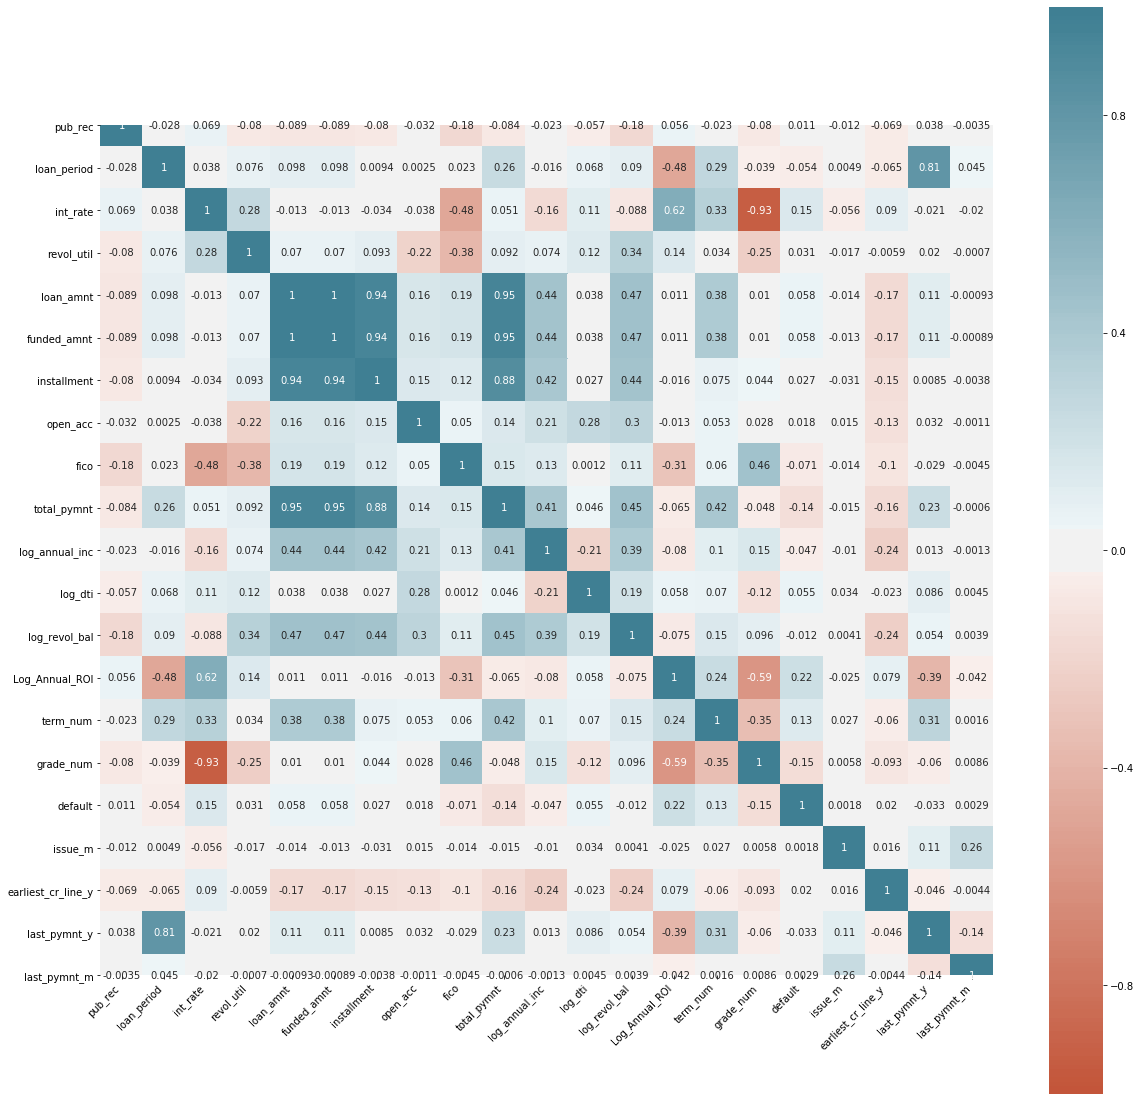

In [23]:
# heatmap

plt.figure(figsize=(20,20))

ax = sns.heatmap(
    df_num[list_feature].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

remove installment, funded_amnt, total_pymnt, grade_num, last_pymnt_y

In [24]:
list_feature.remove('installment')
list_feature.remove('funded_amnt')
list_feature.remove('total_pymnt')
list_feature.remove('grade_num') 
list_feature.remove('last_pymnt_y') 

In [25]:
list_feature

['pub_rec',
 'loan_period',
 'int_rate',
 'revol_util',
 'loan_amnt',
 'open_acc',
 'fico',
 'log_annual_inc',
 'log_dti',
 'log_revol_bal',
 'Log_Annual_ROI',
 'term_num',
 'default',
 'issue_m',
 'earliest_cr_line_y',
 'last_pymnt_m']

In [26]:
# combine numerical variable and categorical variable
df_feature = pd.concat((df_sam[list_feature], df_cat),axis=1)
df_feature.drop(['Log_Annual_ROI'], axis=1, inplace=True) 
df_feature.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,open_acc,fico,log_annual_inc,log_dti,log_revol_bal,term_num,default,issue_m,earliest_cr_line_y,last_pymnt_m,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,...,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
236609,0.0,20.994271,17.57,74.8,13325.0,9.0,684.0,4.623249,1.319938,4.131587,60,1,10,1999,7,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
273214,0.0,25.035422,10.99,37.4,4000.0,10.0,669.0,4.318063,1.154120,3.830781,36,1,8,2009,9,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83110,0.0,16.000329,17.77,75.6,25000.0,13.0,669.0,4.778151,1.211121,4.464936,36,0,6,2004,10,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289411,0.0,32.000657,12.99,23.7,9125.0,11.0,724.0,4.322219,1.211921,4.033142,36,0,7,2002,3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
364895,0.0,36.008953,8.90,77.5,9600.0,8.0,669.0,4.829304,1.351216,3.979002,36,0,3,2005,3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# set X, y
X=df_feature 
y=df_sam['Log_Annual_ROI']

### Train test split

In [28]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [29]:
# Standarization 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

80128 80128 20032 20032


## Model Selection
- use cross validation (cv=10) to avoid overfit
- use GridSearchCV for hyperparameter tuning
- model selection: Linear Regression, Lasso, Ridge, KNN regressor, Random Forest, Gradient Boosting
- use R squared and RMSE as metrics to evaluate model performance

In [31]:
def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    RSq = r2_score(y_test,y_pred)
    print('R Squared: ' + str(RSq))
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    print('RMSE: ' + str(RMSE) +'\n')

### Baseline model

In [32]:
from sklearn.dummy import DummyRegressor
clf_dummy = DummyRegressor(strategy="mean")
clf_dummy.fit(X_train, y_train)

DummyRegressor()

In [33]:
print('Baseline Results:')
print('-Training Metrics-')
model_evaluation(clf_dummy, X_train, y_train)
print('-Testing Metrics-')
model_evaluation(clf_dummy, X_test, y_test)

Baseline Results:
-Training Metrics-
R Squared: 0.0
RMSE: 0.2030406816774912

-Testing Metrics-
R Squared: -2.467842601383552e-07
RMSE: 0.20383226351841258



### Linear Regression 


In [49]:
clf_lreg = LinearRegression()
clf_lreg.fit(X_train, y_train)

LinearRegression()

In [51]:
print('Linear Regression Results:')
print('-Training Metrics-')
model_evaluation(clf_lreg, X_train, y_train)
print('-Testing Metrics-')
model_evaluation(clf_lreg, X_test, y_test)

Linear Regression Results:
-Training Metrics-
R Squared: 0.6899282500169597
RMSE: 0.11306134900674888

-Testing Metrics-
R Squared: 0.6817156647009359
RMSE: 0.11499541003216937



### Lasso

In [34]:
clf_lasso = Lasso()
alpha=[1e-5,1e-4,1e-2,1,5]
param_grid=dict(alpha=alpha)
clf_lasso_cv= GridSearchCV(clf_lasso,param_grid,scoring='neg_mean_squared_error',cv=10)
clf_lasso_cv.fit(X_train, y_train)
print('Best parameter:', clf_lasso_cv.best_params_)
print('Best model:', clf_lasso_cv.best_estimator_)

Best parameter: {'alpha': 0.0001}
Best model: Lasso(alpha=0.0001)


In [37]:
clf_lasso_best= Lasso(alpha=0.0001)
clf_lasso_best.fit(X_train,y_train)

print('Lasso Regression Results:')
print('-Training Metrics-')
model_evaluation(clf_lasso_best, X_train, y_train)
print('-Testing Metrics-')
model_evaluation(clf_lasso_best, X_test, y_test)

Lasso Regression Results:
-Training Metrics-
R Squared: 0.6899184847539606
RMSE: 0.11306312934487302

-Testing Metrics-
R Squared: 0.681805504355395
RMSE: 0.114979179454849



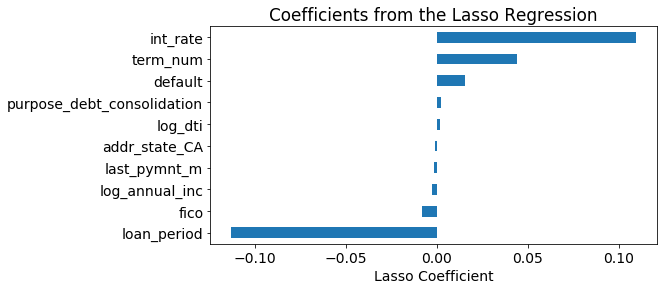

In [40]:
coef_lasso = pd.Series(clf_lasso_best.coef_, index = df_feature.columns)
importance_coef_lasso = pd.concat([coef_lasso.sort_values().head(5),
                     coef_lasso.sort_values().tail(5)])
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))
importance_coef_lasso.plot(kind = "barh")
plt.title("Coefficients from the Lasso Regression")
plt.xlabel('Lasso Coefficient')
plt.show()

### Ridge 

In [55]:
clf_ridge = Ridge()
alpha=[1e-2,1e-1, 1,10,100]
param_grid=dict(alpha=alpha)
clf_ridge_cv= GridSearchCV(clf_ridge,param_grid,scoring='neg_mean_squared_error',cv=10)
clf_ridge_cv.fit(X_train, y_train)
print('Best parameter:', clf_ridge_cv.best_params_)
print('Best model:', clf_ridge_cv.best_estimator_)

Best parameter: {'alpha': 10}
Best model: Ridge(alpha=10)


In [41]:
clf_ridge_best= Ridge(alpha=10)
clf_ridge_best.fit(X_train,y_train)

print('Ridge Regression Results:')
print('-Training Metrics-')
model_evaluation(clf_ridge_best, X_train, y_train)
print('-Testing Metrics-')
model_evaluation(clf_ridge_best, X_test, y_test)

Ridge Regression Results:
-Training Metrics-
R Squared: 0.6899354882554672
RMSE: 0.1130600293609151

-Testing Metrics-
R Squared: 0.6817298917998387
RMSE: 0.11499283989413012



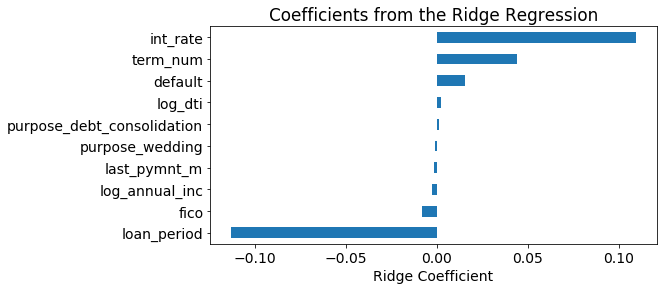

In [43]:
coef_ridge = pd.Series(clf_ridge_best.coef_, index = df_feature.columns)
importance_coef_ridge = pd.concat([coef_ridge.sort_values().head(5),
                     coef_ridge.sort_values().tail(5)])
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))
importance_coef_ridge.plot(kind = "barh")
plt.title("Coefficients from the Ridge Regression")
plt.xlabel('Ridge Coefficient')
plt.show()


### KNN Regressor

In [58]:
from sklearn.neighbors import KNeighborsRegressor

clf_knn = KNeighborsRegressor()
param_grid={'n_neighbors':[5,10,20]}

clf_knn_cv = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=10)
clf_knn_cv.fit(X_train,y_train)

print('Best parameter:', clf_knn_cv.best_params_)
print('Best model:', clf_knn_cv.best_estimator_)

Best parameter: {'n_neighbors': 10}
Best model: KNeighborsRegressor(n_neighbors=10)


In [59]:
clf_knn_best= KNeighborsRegressor(n_neighbors=10)
clf_knn_best.fit(X_train,y_train)

print('KNN Regressor Results:')
print('-Training Metrics-')
model_evaluation(clf_knn_best, X_train, y_train)
print('-Testing Metrics-')
model_evaluation(clf_knn_best, X_test, y_test)

KNN Regressor Results:
-Training Metrics-
R Squared: 0.5846743541247093
RMSE: 0.13085111792680237

-Testing Metrics-
R Squared: 0.48753683760525124
RMSE: 0.14591643140148552



### Random Forest

In [60]:
clf_RF = RandomForestRegressor(criterion='mse')

param_grid = {'n_estimators': [20,50,100,200]}

clf_RF_cv = GridSearchCV(clf_RF, param_grid, scoring='neg_mean_squared_error', cv=10)
clf_RF_cv.fit(X_train,y_train)

print(clf_RF_cv.best_params_)
print(clf_RF_cv.best_score_)
print(clf_RF_cv.best_estimator_)

{'n_estimators': 200}
-0.0034518714381227113
RandomForestRegressor(n_estimators=200)


In [61]:
clf_RF_best= clf_RF_cv.best_estimator_
clf_RF_best.fit(X_train,y_train)

print('Random Forest Regressor Results:')
print('-Training Metrics-')
model_evaluation(clf_RF_best, X_train, y_train)
print('-Testing Metrics-')
model_evaluation(clf_RF_best, X_test, y_test)

Random Forest Regressor Results:
-Training Metrics-
R Squared: 0.9885576444900419
RMSE: 0.021719047810594458

-Testing Metrics-
R Squared: 0.9211483111477131
RMSE: 0.05723719910111326



#### Feature importance

Text(0.5, 0, 'Normalized Gini Importance')

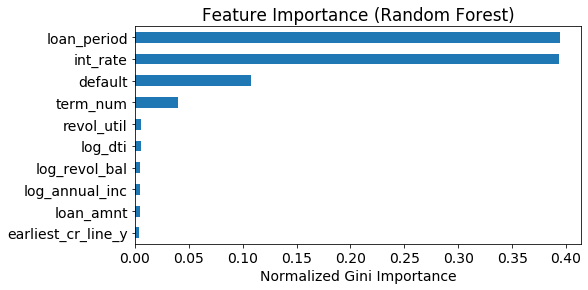

In [81]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))
feat_importances = pd.Series(clf_RF_best.feature_importances_, \
                             index=df_feature.columns)
feat_importances.nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Normalized Gini Importance')

### GradientBoosting

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

In [63]:

clf_RB = GradientBoostingRegressor()

n_estimators = [50,100,200,300]
param_grid = dict(n_estimators=n_estimators)

clf_RB_cv= GridSearchCV(clf_RB , param_grid, scoring='neg_mean_squared_error', cv=10)
clf_RB_cv.fit(X_train,y_train)

print(clf_RB_cv.best_params_)
print(clf_RB_cv.best_score_)
print(clf_RB_cv.best_estimator_)

{'n_estimators': 300}
-0.0037736229091203275
GradientBoostingRegressor(n_estimators=300)


In [34]:
clf_RB_best= GradientBoostingRegressor(n_estimators=300)
clf_RB_best.fit(X_train,y_train)

print('Gradient Booster Regressor Results:')
print('-Training Metrics-')
model_evaluation(clf_RB_best, X_train, y_train)
print('-Testing Metrics-')
model_evaluation(clf_RB_best, X_test, y_test) 

Gradient Booster Regressor Results:
-Training Metrics-
R Squared: 0.9145081379400508
RMSE: 0.05936704754134001

-Testing Metrics-
R Squared: 0.9113523567570995
RMSE: 0.06068850940131213



In [55]:
# save models
import pickle

# save the model to disk
pickle.dump(clf_RB_best, open('GB_reg.sav', 'wb'))

In [58]:
infile = open('GB_reg.sav','rb')
clf_RB_best = pickle.load(infile)
infile.close()

## Model Performance

model: KNN, Lasso, Ridge, Random Forest, Gradient Boosting

In [44]:
name_list = ['KNN','Lasso', 'Ridge', 'Random Forest', 'Gradient Boosting']
RSq_train = [0.5847,0.6899,0.6899,0.9886,0.9145]
RSq_test = [0.4875,0.6818,0.6917,0.9211,0.9113]
RMSE_train =[0.1309,0.1130,0.1131,0.0217,0.0594]
RMSE_test = [0.1459,0.1149,0.1150,0.0572,0.0607]

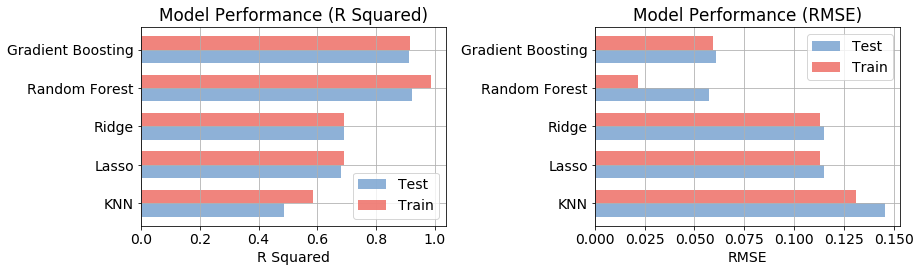

In [47]:
plt.rcParams.update({'font.size': 14})
# Setting the positions and width for the bars
pos = list(range(len(name_list))) 
width = 0.35

# Plotting the bars
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))

ax1.barh(pos, RSq_test, width, alpha=0.8, color='#729ece', label=name_list) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
ax1.barh([p + width for p in pos], \
        RSq_train,width, alpha=0.8, \
        color='#ed665d', label=name_list) 

# Set the y axis label
ax1.set_xlabel('R Squared')
ax1.set_title('Model Performance (R Squared)')
ax1.set_yticks([p + 0.5 * width for p in pos])
ax1.set_yticklabels(name_list)

# Adding the legend and showing the plot
ax1.legend(['Test', 'Train'], loc='best')
ax1.grid()
#plt.show()


ax2.barh(pos, RMSE_test, width, alpha=0.8, \
        color='#729ece', label=name_list) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
ax2.barh([p + width for p in pos], \
        RMSE_train,width, alpha=0.8, \
        color='#ed665d', label=name_list) 

# Set the y axis label
ax2.set_xlabel('RMSE')
ax2.set_title('Model Performance (RMSE)')
ax2.set_yticks([p + 0.5 * width for p in pos])
ax2.set_yticklabels(name_list)

# Adding the legend and showing the plot
ax2.legend(['Test','Train'],loc='best')
ax2.grid()
plt.tight_layout()

### Explainability of ML model

In [37]:
df_feature.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,open_acc,fico,log_annual_inc,log_dti,log_revol_bal,term_num,default,issue_m,earliest_cr_line_y,last_pymnt_m,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,...,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
236609,0.0,20.994271,17.57,74.8,13325.0,9.0,684.0,4.623249,1.319938,4.131587,60,1,10,1999,7,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
273214,0.0,25.035422,10.99,37.4,4000.0,10.0,669.0,4.318063,1.154120,3.830781,36,1,8,2009,9,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83110,0.0,16.000329,17.77,75.6,25000.0,13.0,669.0,4.778151,1.211121,4.464936,36,0,6,2004,10,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289411,0.0,32.000657,12.99,23.7,9125.0,11.0,724.0,4.322219,1.211921,4.033142,36,0,7,2002,3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
364895,0.0,36.008953,8.90,77.5,9600.0,8.0,669.0,4.829304,1.351216,3.979002,36,0,3,2005,3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
import shap

In [54]:
#initiatize JavaScript visulization
shap.initjs()

In [38]:
explainer = shap.TreeExplainer(clf_RB_best)
shap_values = explainer.shap_values(df_feature)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [41]:
shap_values.shape

(100160, 86)

In [42]:
df_feature.shape

(100160, 86)

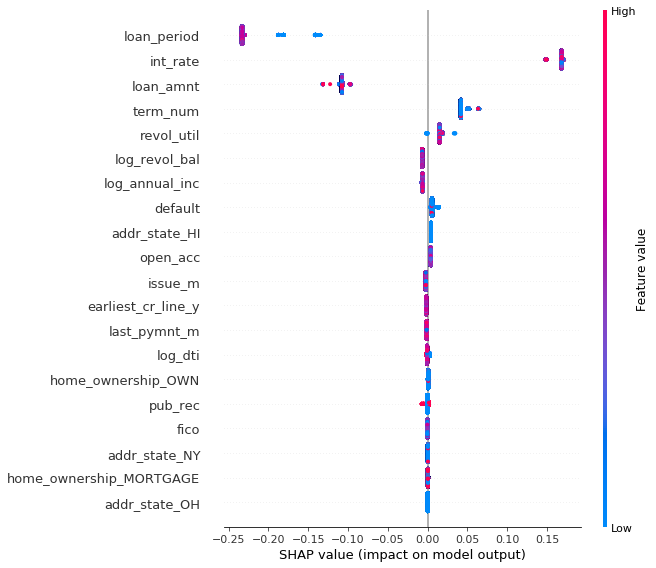

In [44]:
# Plot summary_plot
shap.summary_plot(shap_values, df_feature)

In [ ]:
# Plot summary_plot
shap.summary_plot(shap_values, df_feature, plot_type='bar')

In [45]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df_feature.iloc[0,:])

In [47]:
shap.force_plot(explainer.expected_value, shap_values[100,:], df_feature.iloc[100,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, df_feature)

In [53]:
shap_interaction_values = explainer.shap_interaction_values(df_feature)

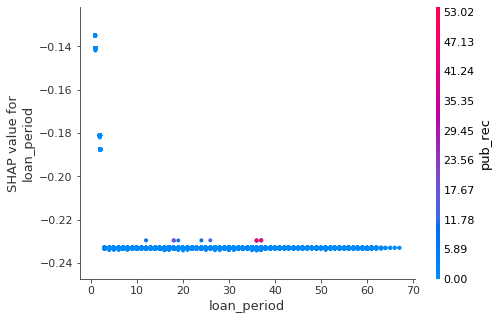

In [52]:
shap.dependence_plot("loan_period", shap_values, df_feature)

### Test investment strategies

In [48]:
# regresion models
df_all = pd.concat((df_feature, df_sam['Log_Annual_ROI']),axis=1) 

In [49]:
df_all_1 = df_all[['default','Log_Annual_ROI']]

In [50]:
df_all_1['AROI'] = 10**df_all_1['Log_Annual_ROI']

In [51]:
df_all_1=df_all_1.reset_index(drop=True)

In [52]:
df_all_1.head()

,default,Log_Annual_ROI,AROI
0,1,-0.514900,0.305562
1,1,-1.051898,0.088736
2,0,-0.841639,0.144000
3,0,-1.130301,0.074080
4,0,-1.341210,0.045582


In [53]:
# random sample

import random
np.random.seed(42)
sample_size=100
list_index = random.sample(range(0, len(y_test)), sample_size) 

In [54]:
AROI_random = df_all_1.loc[list_index,'AROI']
return_ram = np.mean(AROI_random)
print('Return (random) =', return_ram)

Return (random) = 0.09522128136148691


In [59]:
# return predict AROI
y_pred_GB = clf_RB_best.predict(X_test)

In [205]:
return_AROI = 10**np.mean(np.sort(y_pred_GB)[::-1][:100])
print('Return (AROI) =', return_AROI)

Return (AROI) = 0.3516832972442885


In [60]:
# return predict default
df_all_1.head()

,default,Log_Annual_ROI,AROI
0,1,-0.514900,0.305562
1,1,-1.051898,0.088736
2,0,-0.841639,0.144000
3,0,-1.130301,0.074080
4,0,-1.341210,0.045582


In [61]:
df_all_1['AROI'].mean()

0.09211003685449444

In [62]:
return_default = df_all_1[df_all_1['default']==0]['AROI'].mean()
print('Return (default)=', return_default)

Return (default)= 0.08564860243823012


In [63]:
return_default = df_all_1[df_all_1['default']==0].sort_values(['AROI'], ascending=False)[:100]['AROI'].mean()
print('Return (default)=', return_default)

Return (default)= 0.24080649462957268


In [64]:
return_default = df_all_1[df_all_1['default']==1].sort_values(['AROI'], ascending=False)[:100]['AROI'].mean()
print('Return (default)=', return_default)

Return (default)= 0.4055382671624158
